# Imports

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

# pandas profiling

In [88]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df)
# profile

# Data Processing

In [89]:
df = pd.read_csv('data/titanic/train.csv', index_col=0)
val_df = pd.read_csv('data/titanic/test.csv', index_col=0)
def process_data(df):
    df.Sex = pd.Categorical(df.Sex)
    df.Sex = df.Sex.cat.codes
    df.Age.fillna(df.Age.mean(), inplace=True)
    df.Cabin = df.Cabin.fillna('X').apply(lambda x: x[0])
    df = pd.concat([df, df.Cabin.str.get_dummies()], axis=1)
    df = pd.concat([df, pd.get_dummies(data=df.Embarked, prefix='EMB_')], axis=1)
    df['FareLog'] = np.log1p(df.Fare) # New Feature
    df.drop(columns=['Name', 'Ticket', 'Cabin', 'Embarked'], inplace=True, errors='ignore')
    return df

df = process_data(df)
val_df = process_data(val_df) # to jest trochę źle test_df.Age.fillna(train_df.Age.mean())

# Modelling

## Data Splitting

In [90]:
from sklearn.model_selection import train_test_split

y = df.pop('Survived')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
X_val = val_df

## Decision Tree

In [91]:
from sklearn.tree import DecisionTreeClassifier

dectree = DecisionTreeClassifier(max_depth=9, min_samples_leaf=7)
dectree.fit(X_train, y_train)
train_acc = dectree.score(X_train, y_train)
test_acc = dectree.score(X_test, y_test)
train_acc, test_acc

(0.8780096308186196, 0.75)

In [92]:
# dectree.__dict__

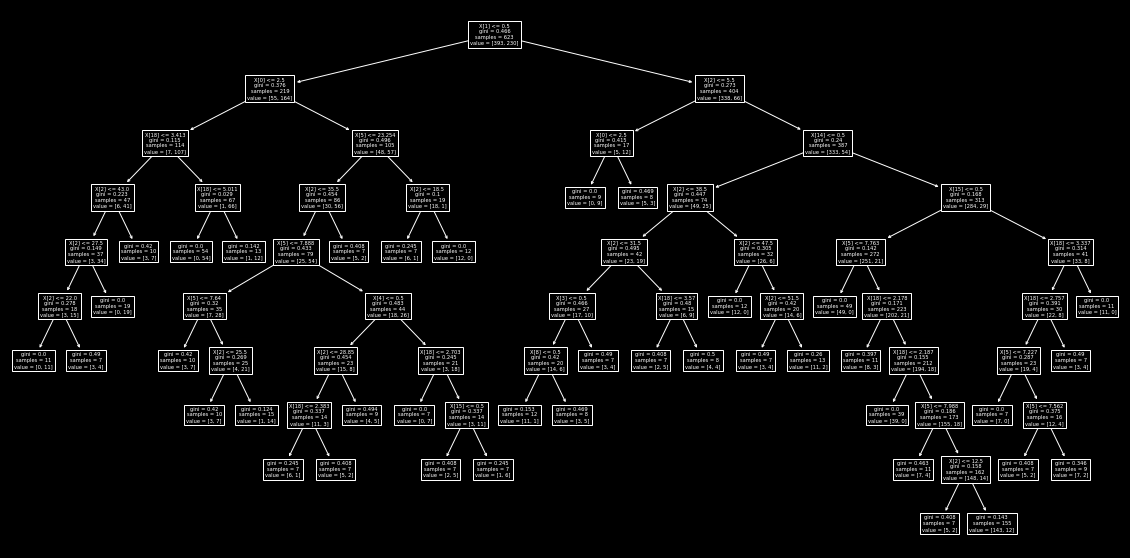

In [93]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

figure(figsize=(20, 10))
plot_tree(dectree)
plt.show()

### Crossvalidation

In [94]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
cv_results = cross_validate(dectree, X, y, cv=5, scoring='accuracy', verbose=1, return_train_score=True)

pd.DataFrame(cv_results).mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


fit_time       0.002779
score_time     0.001303
test_score     0.821599
train_score    0.868966
dtype: float64

## GridSearchCV

In [95]:
from sklearn.model_selection import GridSearchCV

param_space = {
    'min_samples_leaf': range(1, 10), 
    'max_depth': range(1, 10)
}
model = DecisionTreeClassifier()
gs = GridSearchCV(model, param_space, cv=5, verbose=1, return_train_score=True)
gs.fit(X, y)
results = pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').iloc[1, 4:]

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [96]:
results.mean_train_score, results.mean_test_score, results.params

(0.8751406464219865,
 0.8227229929069111,
 {'max_depth': 9, 'min_samples_leaf': 6})

## SVM

### CV

In [97]:
# from sklearn.svm import SVC, SVR
#
# svc = SVC(
#     C=1.0,
#     kernel='rbf',
#     degree=3,
#     gamma='scale',
#     coef0=0.0,
#     verbose=False,
#     random_state=None
# )
#
# cv_results = cross_validate(svc, X, y, cv=5, scoring='accuracy', verbose=1, return_train_score=True)
# pd.DataFrame(cv_results).mean()

### GridSearchCV

In [98]:
# from sklearn.model_selection import GridSearchCV
#
# param_space = [
#     {
#         "kernel": ["linear"],
#         "C": [1, 10, 100, 1000],
#     },
#     {
#         "kernel": ["rbf"],
#         "C": [1, 10, 100, 1000],
#         "gamma": [0.001, 0.0001],
#     },
# ]
# gs = GridSearchCV(svc, param_space, verbose=1, cv=5)
# gs.fit(X, y)
# results = pd.DataFrame(gs.cv_results_).sort_values(by="rank_test_score").iloc[1, 4:]

In [99]:
# results.mean_train_score, results.mean_test_score, results.params

# Predict the submission

In [100]:
X_val['T'] = X_train['T'].mean()

In [101]:
import numpy as np


X_val['Fare'] = X_val['Fare'].fillna(X_train['Fare'].mean())
X_val['FareLog'] = X_val['FareLog'].fillna(X_train['FareLog'].mean())
np.any(np.isnan(X_val))

False

In [105]:
# pd.set_option("display.max_rows", 50, "display.max_columns", None)
X_val.head()
# X_val.isnull().sum()

,Pclass,Sex,Age,SibSp,Parch,Fare,A,B,C,D,E,F,G,X,EMB__C,EMB__Q,EMB__S,FareLog,T
PassengerId,,,,,,,,,,,,,,,,,,,
892,3,1,34.5,0,0,7.8292,0,0,0,0,0,0,0,1,0,1,0,2.178064,0.001605
893,3,0,47.0,1,0,7.0000,0,0,0,0,0,0,0,1,0,0,1,2.079442,0.001605
894,2,1,62.0,0,0,9.6875,0,0,0,0,0,0,0,1,0,1,0,2.369075,0.001605
895,3,1,27.0,0,0,8.6625,0,0,0,0,0,0,0,1,0,0,1,2.268252,0.001605
896,3,0,22.0,1,1,12.2875,0,0,0,0,0,0,0,1,0,0,1,2.586824,0.001605


In [103]:
predicted_df = gs.predict(X_val)
submission_df = pd.DataFrame({'Survived': X_val.index}, index=X_val.index)
submission_df['Survived'] = predicted_df
submission_df.sample(3, random_state=7)

C:\Users\admin\anaconda3\envs\ds_env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,Survived
PassengerId,
1124,0
1115,0
952,1


## Saving submission

In [104]:
submission_df.to_csv('submission.csv')

# Do Domu

- uporządkować notebooki
- wgrać na kaggle wyniki

## Do obejrzenia:

- Jupyter Shortcuts [Video](https://www.youtube.com/watch?v=FW2BF6jbHBk)
- SVM [Blog](https://towardsdatascience.com/i-support-vector-machines-and-so-should-you-7af122b6748)
- pandas_profiling [Blog](https://towardsdatascience.com/fantastic-pandas-data-frame-report-with-pandas-profiling-a05cde64a0e2)